In [1]:
import util
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftshift, fftfreq
from PIL import Image

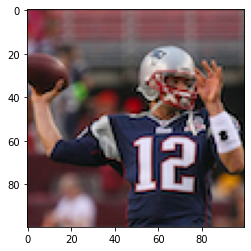

In [2]:
img0 = Image.open('images/brady-medium.jpg')
plt.imshow(img0, cmap='gray')

In [3]:
img, startX, startY = util.pad_img(img0)

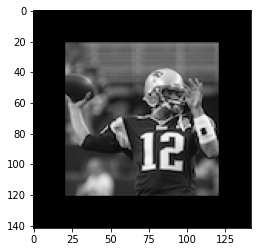

In [4]:
plt.imshow(img,cmap='gray')

In [5]:
angles = np.linspace(0,180,180,endpoint=False)
sinogram = util.projection(img, angles)

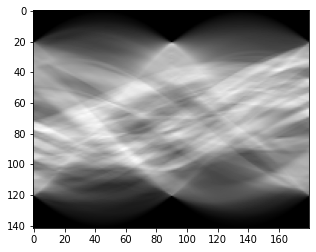

In [6]:
plt.imshow(sinogram, cmap='gray')

Sinogram seems to match online examples for this famous phantom. Let's try with a single point to see a sine wave. Makes sense as it is being rotated about the center so is a sinusoid wrt the rows (compressing image to one row per angle).

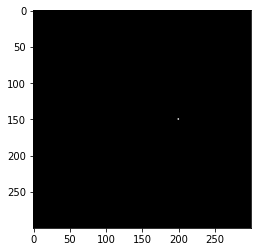

In [7]:
point_img = np.zeros((300, 300))
ptWidth = 1
centerX, centerY = 200, 150
point_img[centerY-ptWidth:centerY+ptWidth,centerX-ptWidth:centerX+ptWidth] = 1

# convert to Image
point_img = Image.fromarray(point_img.astype('uint8')*255)
plt.imshow(point_img,cmap='gray')

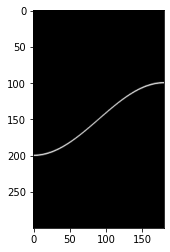

In [8]:
sin_sample_sino = util.projection(point_img, angles)
plt.imshow(sin_sample_sino, cmap='gray')

sine wave as expected. Radon transform of a point.

Now doing Filtered Backprojection

In [9]:
proj_size, num_proj = sinogram.shape
reconstructed_img = np.zeros((proj_size, proj_size))

for i in range(num_proj):
    proj = sinogram[:, i]
    proj_spectrum = fft(proj)
    proj_spectrum = fftshift(proj_spectrum)

    # filter   
    w = np.linspace(-np.pi, np.pi, proj_size)
    ramp_filter = np.abs(w)
    ramp_filter = fftshift(ramp_filter)  

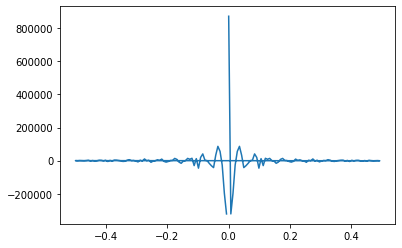

In [10]:
proj_fft = np.real((fft(sinogram[:, 0])))
freqs = fftfreq(len(proj_fft))
plt.plot(freqs, proj_fft)

In [11]:
B = np.max(np.abs(freqs))
rfilt = np.abs(np.linspace(-B, B, proj_size))
rfilt = fftshift(rfilt)

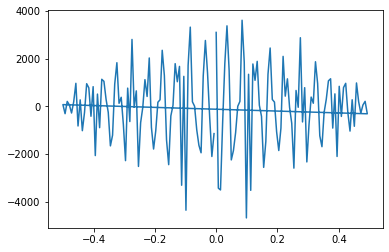

In [12]:
plt.plot(freqs, proj_fft*rfilt)

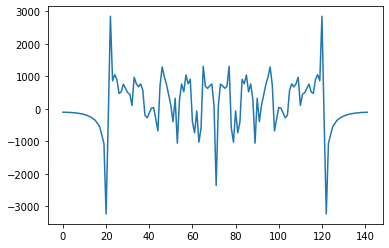

In [13]:
proj_filtered = ifft(proj_fft * ramp_filter)
plt.plot(np.real(proj_filtered))

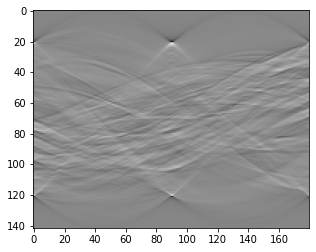

In [14]:
filtered_sino = np.zeros((proj_size, num_proj))

for i in range(num_proj):
    proj = sinogram[:, i]
    proj_fft = fft(proj)
    freqs = fftfreq(len(proj_fft))

    B = np.max(np.abs(freqs))
    rfilt = np.abs(np.linspace(-B, B, proj_size))
    rfilt = fftshift(rfilt)

    proj_filtered = ifft(proj_fft * rfilt)
    filtered_sino[:, i] = np.real(proj_filtered)

plt.imshow(filtered_sino, cmap='gray')

Next idea is to "drag" each sinogram row back across the image in the direction it came. Can do this assuming each one has theta=0 and then rotate back. This approach using np.repeat also inspired by original source for util library.

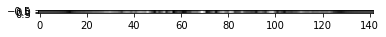

In [15]:
theta = 100
proj = filtered_sino[:, theta]
proj = np.expand_dims(proj, 0)
proj.shape
plt.imshow(proj, cmap='gray')

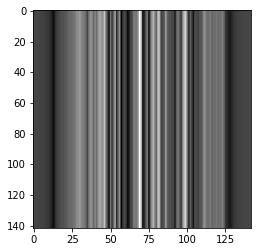

In [16]:
dragged = np.repeat(proj, proj_size)
dragged = dragged.reshape(proj_size, proj_size)
dragged = dragged.T
plt.imshow(dragged, cmap='gray')

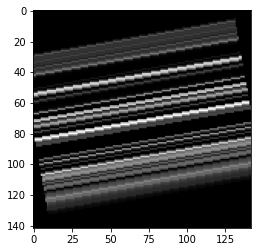

In [17]:
dragged_img = Image.fromarray(dragged)
dragged_img = dragged_img.rotate(theta, expand=False)
plt.imshow(dragged_img, cmap='gray')

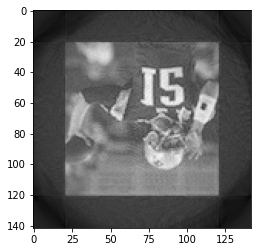

In [18]:
reconstructed = np.zeros((proj_size, proj_size))
frames = [] # for gif

for i in range(num_proj):

    proj = filtered_sino[:, i]
    proj = np.expand_dims(proj, 0)

    dragged = np.repeat(proj, proj_size)
    dragged = dragged.reshape(proj_size, proj_size)
    dragged = dragged.T

    dragged_img = Image.fromarray(dragged)
    dragged_img = dragged_img.rotate(i, expand=False)
    reconstructed += np.array(dragged_img)

    # add partial reconstruction to frames
    frames.append(Image.fromarray(
        np.flipud(reconstructed) / np.max(reconstructed) * 255
    ))

plt.imshow(reconstructed, cmap='gray')


In [19]:
frames[0].save('reconstruction.gif', format='GIF', append_images=frames[1:], save_all=True, duration=50, loop=0)

Upside down.

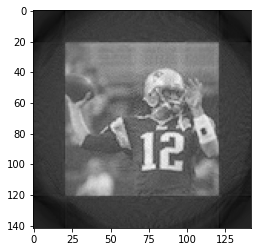

In [20]:
reconstructed = np.flipud(reconstructed)
reconstructed /= np.max(reconstructed)
plt.imshow(reconstructed, cmap='gray')

Now cut off padding.

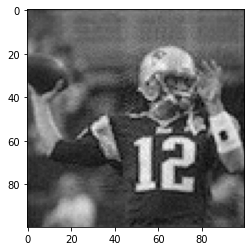

In [21]:
final = reconstructed[startY:startY+img0.size[0], startX:startX+img0.size[1]]
plt.imshow(final, cmap='gray')

Worth noting that in an actual CT/MRI context, this last padding cutoff step would be infeasible because the size of the phantom is unknown.

Measuring error

0.2836849565677534

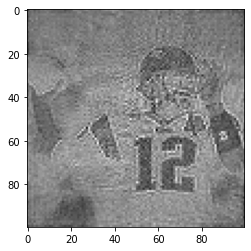

In [22]:
original = np.array(img0.convert('L'))
original = original.astype('float64') / 255.0

error = final - original
plt.imshow(error, cmap='gray')

np.max(error)

In [23]:
np.mean(error)

0.07839227583729699